In [1]:
# https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math
import matplotlib.pyplot as plt

np.random.seed(1337)

# Creating functions

In [2]:
# transform series into train and test sets for supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [3]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values

    # transform data to be stationary
    diff_values = raw_values
    diff_values = diff_values.reshape(len(diff_values), 1)

    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)

    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values

    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [4]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]

    X = X.reshape(X.shape[0], 1, X.shape[1])

    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss="mean_squared_error", optimizer="adam")

    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=2, shuffle=False)

    return model

In [5]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))

    # make forecast
    forecast = model.predict(X, batch_size=n_batch)

    # convert to array
    return [x for x in forecast[0, :]]

In [6]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq, forecast_len):
    forecasts = list()
    print(f'Forecast x of {forecast_len}:', end=" ")
    for i in range(forecast_len):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)

        # Printing current status in hundreds
        step = i % 10
        if step == 0:
            print(i, end=" ")

    return forecasts

In [7]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler):
    inverted = list()
    for i in range(len(forecasts)):

        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))

        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]

        inverted.append(inv_scale)

    return inverted

# Fitting and predicting

In [8]:
# load dataset
logreturns = "data/final.csv"
series = pd.read_csv(logreturns, usecols=["Exchange.Date", "logreturns"], header=0, index_col=0, squeeze=True)

# configure
n_lag = 5 # same as ARMA-GARCH
n_seq = 63  #  number of periods forecast
test_share = 0.25
n_test = int(len(series) * test_share)
n_epochs = 5
n_batch = 1
n_neurons = 50
forecast_len = 100

print("Preparing data...")
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

print("Fitting model...")
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

print("Making forecasts...")
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq, forecast_len)

print("\nInverting forecasts...")
forecasts = inverse_transform(series, forecasts, scaler)
print("Done!")

Preparing data...
Fitting model...
Epoch 1/5
3356/3356 - 5s - loss: 0.0086
Epoch 2/5
3356/3356 - 3s - loss: 0.0078
Epoch 3/5
3356/3356 - 3s - loss: 0.0077
Epoch 4/5
3356/3356 - 3s - loss: 0.0077
Epoch 5/5
3356/3356 - 3s - loss: 0.0077
Making forecasts...
Forecast x of 100: 0 10 20 30 40 50 60 70 80 90 
Inverting forecasts...
Done!


# Evaluating from t=1


## Creating dataframe for evaluation
In essence, creating a new DF combining training data (historic) and forecasts

In [9]:
# Getting dataframe with Close as well and the creating a training df same size as used in the model
original_df = pd.read_csv("data/final.csv", usecols=["Exchange.Date", "logreturns", "Close"])

# Setting as date
original_df['Exchange.Date'] = original_df['Exchange.Date'].apply(lambda x: date(1900, 1, 1) + timedelta(int(x)))
original_df.index = original_df['Exchange.Date']

train_df = original_df[:-n_test].copy()

# Assigning all rows in train df (before forecast) to closing value
# This is because this column cannot be empty (and we have no forecasts since it's training data)
train_df["forecast"] = train_df["Close"]

In [10]:
# Transforming logreturns back to price
last_train = train_df["Close"].values[-1]
price_forecasts = np.exp(np.cumsum(forecasts[0]) + math.log(last_train))

In [11]:
# Creating a separate dataframe only for forecasts (i.e. "outside train df")
forecast_df = pd.DataFrame(columns=["Exchange.Date", "Close", "logreturns", "forecast"])
forecast_df["Close"] = original_df["Close"].values[-n_test : -n_test + n_seq]
forecast_df["logreturns"] = original_df["logreturns"].values[-n_test : -n_test + n_seq]
forecast_df["forecast"] = price_forecasts
forecast_df.index

forecast_df["Exchange.Date"] = forecast_df.index.map(lambda x: date(2016, 8, 1) + timedelta(int(x)))
forecast_df.index = forecast_df["Exchange.Date"]

In [12]:
# Merging train and forecast dataframe
merged_df = train_df.append(forecast_df, ignore_index=True)

# Creating error, absolute error, actual price going up (True/False) and forecast going up (True/False)
merged_df["error"] = merged_df["forecast"] - merged_df["Close"]
merged_df["abs_error"] = np.abs(merged_df["forecast"] - merged_df["Close"])
merged_df["actual_up"] = merged_df["Close"].diff(1) > 0
merged_df["forecast_up"] = merged_df["forecast"].diff(1) > 0
merged_df.index = merged_df["Exchange.Date"]

# Formula for creating confusion value, used below
def confusion(actual, forecast):
    if actual and forecast:
        return "TP"

    if actual and not forecast:
        return "FN"

    if not actual and forecast:
        return "FP"

    if not actual and not forecast:
        return "TN"

    # Just common programming sense to return something, could have written "blabla"
    return False


# The lambda stuff applies the above function on every row of data
merged_df["confusion"] = merged_df.apply(lambda x: confusion(x["actual_up"], x["forecast_up"]), axis=1)

# Printing the tail of the data
merged_df.tail()

,Exchange.Date,Close,logreturns,forecast,error,abs_error,actual_up,forecast_up,confusion
Exchange.Date,,,,,,,,,
2016-09-28,2016-09-28,671.89,0.005567,650.408142,-21.481858,21.481858,True,True,TP
2016-09-29,2016-09-29,671.08,-0.001206,651.394836,-19.685164,19.685164,False,True,FP
2016-09-30,2016-09-30,668.82,-0.003373,652.551025,-16.268975,16.268975,False,True,FP
2016-10-01,2016-10-01,668.02,-0.001197,653.654114,-14.365886,14.365886,False,True,FP
2016-10-02,2016-10-02,663.33,-0.007046,654.815247,-8.514753,8.514753,False,True,FP


## Evaluating

In [13]:
# New dataframe that only contains the number of periods to evaluate (1,3,5,21,63)
def new_df(n_periods):
    df = merged_df[len(train_df) : len(train_df) + n_periods]
    return df

In [14]:
# Creating RMSE AND MAE
def evaluate(n_periods):
    df = new_df(n_periods)
    mape = ((df["abs_error"] / df["Close"]).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df["error"].sum(), 2) / n_periods)
    print(f"{n_periods}, RMSE: {round(rmse, 3)}, MAPE: {round(mape, 3)}%")


evaluate(1)  # 1 day
evaluate(3)  # half a week
evaluate(5)  # week
evaluate(21)  # month
evaluate(63)  # quarter

1, RMSE: 0.632, MAPE: 0.101%
3, RMSE: 6.209, MAPE: 0.648%
5, RMSE: 8.318, MAPE: 0.641%
21, RMSE: 2.227, MAPE: 0.506%
63, RMSE: 62.499, MAPE: 1.423%


In [15]:
# Creating confusion matrix
def confusion_matrix(df):
    conf = pd.DataFrame(columns=["P", "N"], index=["P", "N"])
    conf.loc["P", "P"] = len(df[df["confusion"] == "TP"])
    conf.loc["P", "N"] = len(df[df["confusion"] == "FN"])
    conf.loc["N", "P"] = len(df[df["confusion"] == "FP"])
    conf.loc["N", "N"] = len(df[df["confusion"] == "TN"])
    return conf


confusion = confusion_matrix(new_df(63))
precision = confusion.iloc[0, 0] / (confusion.iloc[0, 0] + confusion.iloc[0, 1])
recall = confusion.iloc[0, 0] / (confusion.iloc[0, 0] + confusion.iloc[1, 0])
f_score = 2 * precision * recall / (precision + recall)

print(confusion)
print(f"precision: {int(precision*100)}%, recall: {int(recall*100)}%, f-score: {round(f_score, 3)}")

    P  N
P  34  3
N  25  1
precision: 91%, recall: 57%, f-score: 0.708


# Plotting

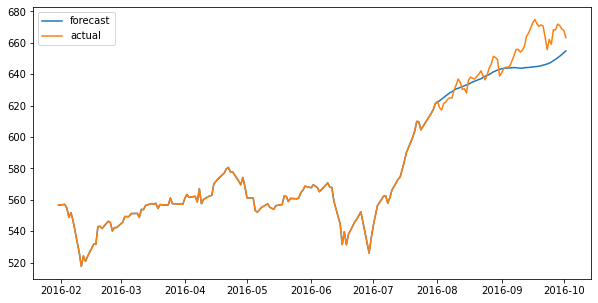

In [16]:
plot_df = merged_df[-n_seq - (n_seq * 2) :]
plt.figure(figsize=(10, 5))
plt.plot(plot_df["forecast"], label="forecast")
plt.plot(plot_df["Close"], label="actual")
plt.legend()

# Cross-validation

In [17]:
def cross_evaluate(df, n_periods):
    df = df[-63:-63+n_periods] if n_periods < 63 else df.tail(63)
    mape = ((df["abs_error"] / df["Close"]).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df["error"].sum(), 2) / n_periods)
    return mape, rmse

cross_df = pd.DataFrame(columns=[
    "mape_1", 
    "mape_3",
    "mape_5",
    "mape_21",
    "mape_63",
    "rmse_1",
    "rmse_3",
    "rmse_5",
    "rmse_21",
    "rmse_63"
])

for i in range(len(forecasts)):
    train_df = original_df[:-n_test + i].copy()
    train_df["forecast"] = train_df["Close"]

    last_train = train_df["Close"].values[-1]
    price_forecasts = np.exp(np.cumsum(forecasts[i]) + math.log(last_train))

    cross_merged_df = original_df[-n_test + i:-n_test + i + 63].copy()
    cross_merged_df["forecast"] = price_forecasts

    cross_merged_df["error"] = cross_merged_df["forecast"] - cross_merged_df["Close"]
    cross_merged_df["abs_error"] = np.abs(cross_merged_df["forecast"] - cross_merged_df["Close"])

    one = cross_evaluate(cross_merged_df, 1)
    three = cross_evaluate(cross_merged_df, 3)
    five = cross_evaluate(cross_merged_df, 5)
    twentyone = cross_evaluate(cross_merged_df, 21)
    sixtythree = cross_evaluate(cross_merged_df, 63)

    cross_df = cross_df.append({
        'mape_1': one[0],
        'mape_3': three[0],
        'mape_5': five[0],
        'mape_21': twentyone[0],
        'mape_63': sixtythree[0],
        'rmse_1': one[1],
        'rmse_3': three[1],
        'rmse_5': five[1],
        'rmse_21': twentyone[1],
        'rmse_63': sixtythree[1],
    }, ignore_index=True)

cross_df

,mape_1,mape_3,mape_5,mape_21,mape_63,rmse_1,rmse_3,rmse_5,rmse_21,rmse_63
0,0.101453,0.648180,0.641285,0.506451,1.422511,0.631816,6.208504,8.318077,2.227011,62.499402
1,0.764120,0.839820,0.701553,0.700568,2.251949,4.727612,8.998179,9.723843,7.158185,110.426363
2,0.383210,0.227058,0.233129,0.743742,1.964589,2.364863,0.295665,1.124076,20.183119,102.117253
3,0.482408,0.452791,0.372039,0.612288,1.257879,2.997102,4.882421,5.184428,16.214796,60.834990
4,0.034582,0.026593,0.142345,0.624636,2.043118,0.215208,0.015109,0.760794,16.564916,106.318505
...,...,...,...,...,...,...,...,...,...,...
95,0.031640,0.327862,0.759461,1.933007,6.262649,0.219810,3.726563,11.788587,63.794238,383.483761
96,0.154840,0.711107,0.983234,2.160934,6.570028,1.078555,8.662106,15.518721,71.538282,402.726118
97,0.644059,1.026314,0.876415,2.168072,6.509731,4.520718,12.555745,13.834303,72.064862,399.638991
98,0.414822,0.613051,0.507229,2.373932,7.538218,2.924993,7.511309,7.824733,79.220171,463.638690


In [18]:
cross_df.describe()

,mape_1,mape_3,mape_5,mape_21,mape_63,rmse_1,rmse_3,rmse_5,rmse_21,rmse_63
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.439012,0.660720,0.797251,1.572934,4.835013,2.901962,6.935943,10.248982,42.555393,268.360587
std,0.391065,0.466680,0.529108,0.851747,1.982714,2.583522,5.677366,8.698770,30.314470,127.300679
min,0.005483,0.026593,0.142345,0.506451,1.078904,0.035933,0.015109,0.170371,0.134394,2.800273
25%,0.154043,0.352886,0.400246,0.943792,3.184989,1.061265,2.700347,3.236241,21.689729,163.870715
50%,0.358204,0.567794,0.688022,1.285199,5.048434,2.360648,5.776234,8.015509,36.293725,276.956121
75%,0.587502,0.848383,1.057257,2.134421,6.458484,3.969079,9.371212,15.197847,63.309587,379.325259
max,1.902999,2.981838,3.243465,5.138110,9.126484,12.864084,34.770310,48.911740,161.998784,524.465377


In [19]:
upper = cross_df.mean() + 1.984 * cross_df.std() / math.sqrt(100)
lower = cross_df.mean() - 1.984 * cross_df.std() / math.sqrt(100)

ci_df = pd.DataFrame(columns=['measure', 'mean', 'lower', 'upper'])

for i in range(10):
    ci_df = ci_df.append({
        'measure': cross_df.columns[i],
        'mean': cross_df.mean()[i],
        'lower': lower[i],
        'upper': upper[i]
    }, ignore_index=True)

ci_df

,measure,mean,lower,upper
0,mape_1,0.439012,0.361425,0.516600
1,mape_3,0.660720,0.568131,0.753309
2,mape_5,0.797251,0.692276,0.902226
3,mape_21,1.572934,1.403947,1.741921
4,mape_63,4.835013,4.441642,5.228383
5,rmse_1,2.901962,2.389391,3.414533
6,rmse_3,6.935943,5.809554,8.062333
7,rmse_5,10.248982,8.523146,11.974818
8,rmse_21,42.555393,36.541002,48.569784
9,rmse_63,268.360587,243.104132,293.617041
